In [42]:
from collections import defaultdict


import numpy as np
import numpy.ma as ma  

import pandas as pd
from joblib import  load


import modlamp.descriptors
import modlamp.analysis
import modlamp.sequences

from amp.data_utils.sequence import to_one_hot, pad
from amp.inference import HydrAMPGenerator



import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

sns.set_style(
    'whitegrid', 
    {
        'grid.color': '.95',
        'axes.spines.right': False,
        'axes.spines.top': False
    }
)

params = {
    'axes.labelsize': 6,
    'axes.titlesize':6,
    'font.size': 6, 
    'legend.fontsize': 5,
    'xtick.labelsize': 6, 
    'ytick.labelsize': 6
}

plt.rcParams.update(params)

In [2]:
palette_models = {  
    'HydrAMP': '#B80018',       
    'PepCVAE': '#1d3557',
    'Basic': '#B4C5E4',
    'AMP-LM': '#57CC99',
    'Dean-VAE': '#DE6897',
    'Muller-LSTM': '#73D2DE',
    'AMP-GAN': '#FA9F42',        
}


TEMPS = {
    'HydrAMP': [1, 2, 5],
    'PepCVAE': [1],
    'Basic': [1],
}

# Read classifiers

In [4]:
generator = HydrAMPGenerator(
    f'../../models/HydrAMP/37/',
    f'../../models/HydrAMP/pca_decomposer.joblib',
)    

amp_classifier, mic_classifier = generator._amp_classifier, generator._mic_classifier 

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


In [5]:
def get_preditions(data: list, amp_classifier, mic_classifier):
    classifier_input = pad(to_one_hot(np.array(data)))
    amp = amp_classifier.predict(classifier_input, batch_size=1000)
    mic = mic_classifier.predict(classifier_input, batch_size=1000)
    return amp, mic

In [6]:
# Read peptides from Nagajaran et al. 2018 
amplm_peptides = pd.read_csv(
    '../../data/benchmarks_data/AMP-LM/lstm.sample',
    header=None,
    skip_blank_lines=False
)
amplm_peptides.columns = ['sequence']
amplm_peptides = amplm_peptides.dropna()
amplm_peptides = amplm_peptides[~amplm_peptides.sequence.str.contains('X')]
amplm_peptides = amplm_peptides[~amplm_peptides.sequence.str.contains('U')]
amplm_peptides = amplm_peptides[amplm_peptides['sequence'].str.len() < 25]

amplm_peptides['amp'], amplm_peptides['mic'] = get_preditions(
    amplm_peptides.sequence,
    amp_classifier,
    mic_classifier
)

In [7]:
# Read peptides from Dean et al. 2020
deanvae_peptides = pd.read_excel('../../data/benchmarks_data/Dean-VAE/ao0c00442_si_003.xlsx', engine='openpyxl')
deanvae_peptides = deanvae_peptides[(deanvae_peptides['step'] == 'active') | (deanvae_peptides['step'] == '0.99')]
deanvae_peptides = deanvae_peptides[~deanvae_peptides.sequence.str.contains('X')]
deanvae_peptides = deanvae_peptides[~deanvae_peptides.sequence.str.contains('U')]
deanvae_peptides = deanvae_peptides[deanvae_peptides['sequence'].str.len() < 25]
deanvae_peptides['amp'], deanvae_peptides['mic'] = get_preditions(
    deanvae_peptides.sequence,
    amp_classifier,
    mic_classifier
)

In [12]:
# Read peptides from Muller et al. 2018
! awk 'BEGIN{RS=">"}{print $1","$2;}' ../../data/benchmarks_data/Muller-LSTM/supplementary_S3.fasta \
| tail -n+2 > ../../data/benchmarks_data/Muller-LSTM/supplementary_S3.csv

mullerlstm_peptides = pd.read_csv('../../data/benchmarks_data/Muller-LSTM/supplementary_S3.csv', header=None)
mullerlstm_peptides.columns = ['name', 'sequence']
mullerlstm_peptides = mullerlstm_peptides.dropna()

mullerlstm_peptides = mullerlstm_peptides[~mullerlstm_peptides.sequence.str.contains('B')]
mullerlstm_peptides = mullerlstm_peptides[~mullerlstm_peptides.sequence.str.contains('X')]
mullerlstm_peptides = mullerlstm_peptides[~mullerlstm_peptides.sequence.str.contains('U')]
mullerlstm_peptides = mullerlstm_peptides[mullerlstm_peptides['sequence'].str.len() < 25]

mullerlstm_peptides['amp'], mullerlstm_peptides['mic'] = get_preditions(
    mullerlstm_peptides.sequence,
    amp_classifier,
    mic_classifier
)

In [13]:
# Generated 100K sequences
# Read amp-gan peptides
ampgan_peptides = pd.read_csv('../../data/benchmarks_data/amp-gan/generated_samples_trunc_2022-08-04.csv')
ampgan_peptides['amp'], ampgan_peptides['mic'] = get_preditions(
    ampgan_peptides.sequence,
    amp_classifier,
    mic_classifier
)
# Get rid of seqs > 25 and get 50K seq to compare with hydramp
ampgan_peptides = ampgan_peptides[ampgan_peptides['sequence'].str.len() < 26].iloc[:50000]

In [14]:
# The number of peptides in each dataset
ampgan_peptides # 50000
deanvae_peptides # 2973
mullerlstm_peptides # 1552
amplm_peptides # 28875

,sequence,amp,mic
0,SLFKGLIQQKLQT,0.117565,0.000029
1,GLKDIIKGAAKGFVKTVAGHIANE,0.999586,0.999935
2,GLGSILGKALKIGAKALATHLAS,0.999992,0.999951
3,DLGKEIAGVLGKTVLKGLK,0.992231,0.000094
5,KFLPLLAKLAAKHLPKLL,0.999983,0.998930
...,...,...,...
30825,FLALR,0.129531,0.000051
30826,NFVRHVVHAVEKAA,0.089814,0.000007
30827,GFFRQLIHRLWKFYE,0.975645,0.272287
30828,AAWGDTILTLAKFLDGVSL,0.024234,0.000006


In [17]:
hydra_results = load(f'../../results/unconstrained_HydrAMP.joblib')
pepcvae_results = load(f'../../results/unconstrained_PepCVAE.joblib')
basic_results = load(f'../../results/unconstrained_Basic.joblib')

In [18]:
def select_peptides(results):
    peptides = np.array(results['pos_peptides']).reshape(64, -1).T
    amp = (results['pos_class_prediction'] < 0.8).reshape(64, -1)
    mic = results['pos_mic_prediction'].reshape(64, -1)
    combined = ma.masked_where(amp, mic)
    good = combined.argmax(axis=0)
    good_peptides = peptides[list(range(peptides.shape[0])), good]
    good_amp = np.array(results['pos_class_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
    good_mic = np.array(results['pos_mic_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
    return pd.DataFrame.from_dict({
        'sequence': good_peptides.tolist(), 
        'amp': good_amp.tolist(),
        'mic': good_mic.tolist(),
    }
    )

In [107]:
pos_amp_data={
    'HydrAMP': hydra_results['pos_class_prediction'].reshape(64, -1).max(axis=0),
    'PepCVAE': pepcvae_results['pos_class_prediction'].reshape(64, -1).max(axis=0),        
    'Basic': basic_results['pos_class_prediction'].reshape(64, -1).max(axis=0),
    'AMP-LM': np.array(amplm_peptides.amp),
    'Dean-VAE': np.array(deanvae_peptides.amp),    
    'Muller-LSTM': np.array(mullerlstm_peptides.amp),
    'AMP-GAN': np.array(ampgan_peptides.amp),
}

neg_amp_data={
    'HydrAMP': hydra_results['neg_class_prediction'].reshape(64, -1).min(axis=0),            
    'PepCVAE': pepcvae_results['neg_class_prediction'].reshape(64, -1).min(axis=0),
    'Basic': basic_results['neg_class_prediction'].reshape(64, -1).min(axis=0),  
}

pos_mic_data={
    'HydrAMP': hydra_results['pos_mic_prediction'].reshape(64, -1).max(axis=0),
    'PepCVAE': pepcvae_results['pos_mic_prediction'].reshape(64, -1).max(axis=0),        
    'Basic': basic_results['pos_mic_prediction'].reshape(64, -1).max(axis=0),
    'AMP-LM': np.array(amplm_peptides.mic),
    'Dean-VAE': np.array(deanvae_peptides.mic),    
    'Muller-LSTM': np.array(mullerlstm_peptides.mic),
    'AMP-GAN': np.array(ampgan_peptides.mic),
}

neg_mic_data={
    'HydrAMP': hydra_results['neg_mic_prediction'].reshape(64, -1).min(axis=0),            
    'PepCVAE': pepcvae_results['neg_mic_prediction'].reshape(64, -1).min(axis=0),
    'Basic': basic_results['neg_mic_prediction'].reshape(64, -1).min(axis=0),  
}

In [145]:
dict_means = {k: v.mean() for k, v in pos_amp_data.items()}
dict_medians = {k: np.median(v) for k, v in pos_amp_data.items()}
dict_stds = {k: np.std(v) for k, v in pos_amp_data.items()}

dd = defaultdict(list)

for d in (dict_means, dict_medians, dict_stds): 
    for key, value in d.items():
        dd[key].append(value)
        
pos_amp = pd.DataFrame.from_dict(dd)
pos_amp.index = ['means', 'medians', 'stds']
pos_amp.to_csv('SourceData_Figure4a.csv')


pos_amp_percentiles = {k: np.percentile(v, [25, 50, 75]) for k, v in pos_amp_data.items()}
pos_amp_percentiles = pd.DataFrame.from_dict(pos_amp_percentiles)
pos_amp_percentiles.index = ['25', '50', '75']
pos_amp_percentiles.to_csv('SourceData_Figure4a_percentiles.csv')


In [146]:
dict_means = {k: v.mean() for k, v in neg_amp_data.items()}
dict_medians = {k: np.median(v) for k, v in neg_amp_data.items()}
dict_stds = {k: np.std(v) for k, v in neg_amp_data.items()}

dd = defaultdict(list)

for d in (dict_means, dict_medians, dict_stds): 
    for key, value in d.items():
        dd[key].append(value)

neg_amp_data = pd.DataFrame.from_dict(dd)
neg_amp_data.index = ['means', 'medians', 'stds']
neg_amp_data.to_csv('SourceData_Figure4b.csv')

neg_amp_percentiles = {k: np.percentile(v, [25, 50, 75]) for k, v in neg_amp_data.items()}
neg_amp_percentiles = pd.DataFrame.from_dict(neg_amp_percentiles)
neg_amp_percentiles.index = ['25', '50', '75']
neg_amp_percentiles.to_csv('SourceData_Figure4b_percentiles.csv')


In [147]:
dict_means = {k: v.mean() for k, v in pos_mic_data.items()}
dict_medians = {k: np.median(v) for k, v in pos_mic_data.items()}
dict_stds = {k: np.std(v) for k, v in pos_mic_data.items()}

dd = defaultdict(list)

for d in (dict_means, dict_medians, dict_stds): 
    for key, value in d.items():
        dd[key].append(value)
        
pos_mic_dict = pd.DataFrame.from_dict(dd)
pos_mic_dict.index = ['means', 'medians', 'stds']
pos_mic_dict.to_csv('SourceData_Figure4c.csv')

pos_mic_percentiles = {k: np.percentile(v, [25, 50, 75]) for k, v in pos_mic_data.items()}
pos_mic_percentiles = pd.DataFrame.from_dict(pos_mic_percentiles)
pos_mic_percentiles.index = ['25', '50', '75']
pos_mic_percentiles.to_csv('SourceData_Figure4c_percentiles.csv')


In [148]:
dict_means = {k: v.mean() for k, v in neg_mic_data.items()}
dict_medians = {k: np.median(v) for k, v in neg_mic_data.items()}
dict_stds = {k: np.std(v) for k, v in neg_mic_data.items()}

dd = defaultdict(list)

for d in (dict_means, dict_medians, dict_stds): 
    for key, value in d.items():
        dd[key].append(value)
        
neg_mic_dict = pd.DataFrame.from_dict(dd)
neg_mic_dict.index = ['means', 'medians', 'stds']
neg_mic_dict.to_csv('SourceData_Figure4d.csv')

neg_mic_percentiles = {k: np.percentile(v, [25, 50, 75]) for k, v in neg_mic_data.items()}
neg_mic_percentiles = pd.DataFrame.from_dict(neg_mic_percentiles)
neg_mic_percentiles.index = ['25', '50', '75']
neg_mic_percentiles.to_csv('SourceData_Figure4d_percentiles.csv')


In [129]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, data, k):
    quartile1, medians, quartile3 = np.array([np.percentile(data_, [25, 50, 75]) for data_ in data]).T
    whiskers = np.array([
        adjacent_values(sorted(array), q1, q3)
        for array, q1, q3 in zip(data, quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='o', lw=0.5, edgecolors='k', color='white', s=10, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=0.75)
#     ax.hlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=0.5)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks([2])
    ax.set_xticklabels([k])

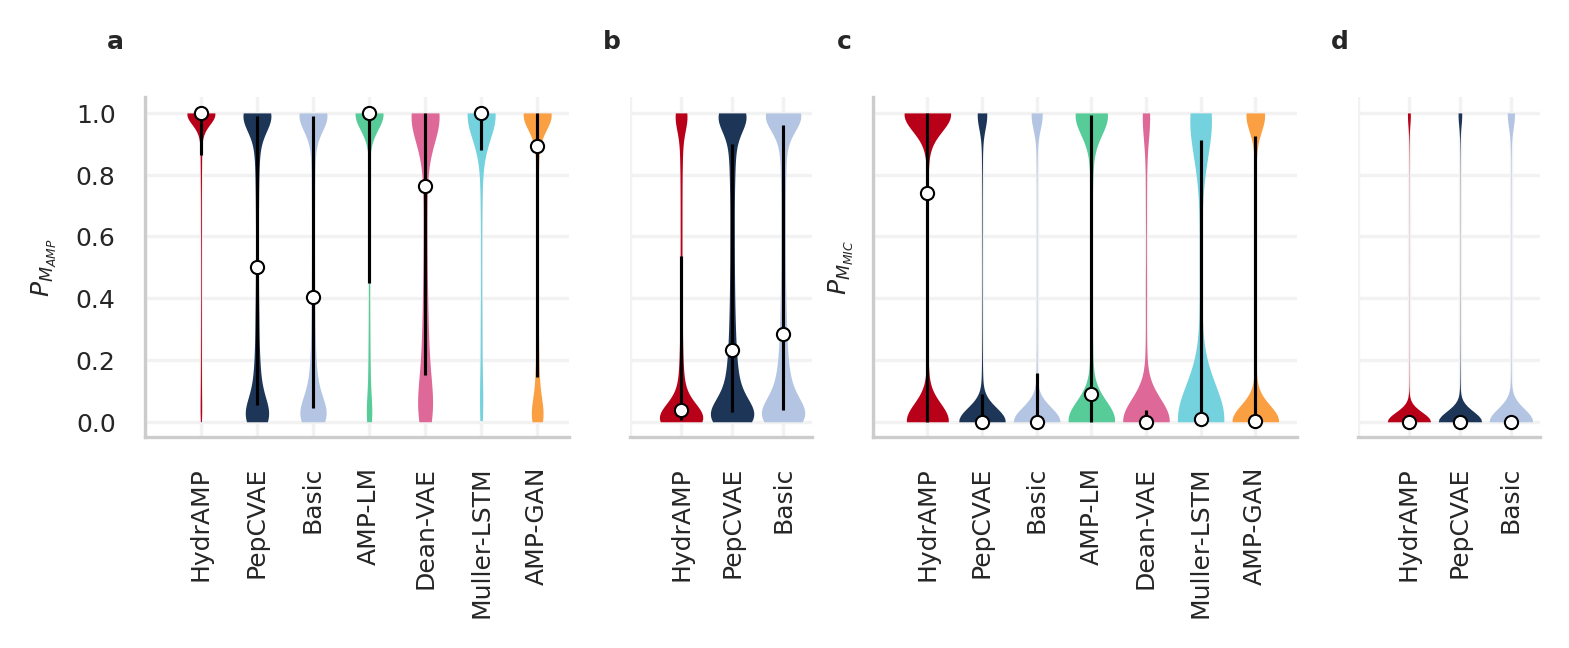

In [130]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(6, 1.5),
    dpi=300,
    sharey=True,
    gridspec_kw={'width_ratios': [7, 3, 7, 3]},
    
#     constrained_layout=True
)

data=[
    hydra_results['pos_class_prediction'].reshape(64, -1).max(axis=0),
    pepcvae_results['pos_class_prediction'].reshape(64, -1).max(axis=0),        
    basic_results['pos_class_prediction'].reshape(64, -1).max(axis=0),
    np.array(amplm_peptides.amp),
    np.array(deanvae_peptides.amp),    
    np.array(mullerlstm_peptides.amp),
    np.array(ampgan_peptides.amp),
]

parts1 = ax1.violinplot(dataset=data,
    showmeans=False,
    showmedians=False,
    showextrema=False,

)
set_axis_style(ax1, data, 'Positive mode')

data=[
    hydra_results['neg_class_prediction'].reshape(64, -1).min(axis=0),            
    pepcvae_results['neg_class_prediction'].reshape(64, -1).min(axis=0),
    basic_results['neg_class_prediction'].reshape(64, -1).min(axis=0),  
]

parts2 = ax2.violinplot(dataset=data,
    showmeans=False,
    showmedians=False,
    showextrema=False,
    widths=0.85, 
)

set_axis_style(ax2, data, 'Negative mode')

data=[
    hydra_results['pos_mic_prediction'].reshape(64, -1).max(axis=0),
    pepcvae_results['pos_mic_prediction'].reshape(64, -1).max(axis=0),        
    basic_results['pos_mic_prediction'].reshape(64, -1).max(axis=0), 
    np.array(amplm_peptides.mic),
    np.array(deanvae_peptides.mic),
    np.array(mullerlstm_peptides.mic),
    np.array(ampgan_peptides.mic)
    
]

parts3 = ax3.violinplot(dataset=data,
    showmeans=False,
    showmedians=False,
    showextrema=False,
    widths=0.85, 
)

set_axis_style(ax3, data, 'Positive mode')

data=[
    hydra_results['neg_mic_prediction'].reshape(64, -1).min(axis=0),            
    pepcvae_results['neg_mic_prediction'].reshape(64, -1).min(axis=0),
    basic_results['neg_mic_prediction'].reshape(64, -1).min(axis=0),   
]

parts4 = ax4.violinplot(dataset=data,
    showmeans=False,
    showmedians=False,
    showextrema=False,
    widths=0.85, 
)

for parts in [parts1, parts2, parts3, parts4]:
    for pc, color in zip(parts['bodies'], palette_models.values()):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_linewidth(0.0)
        pc.set_alpha(1)
        
set_axis_style(ax4, data, 'Negative mode')
for ax in [ax2, ax4]:
    ax.spines['left'].set_visible(False)

ax1.set_ylabel('$P_{M_{AMP}}$')
ax3.set_ylabel('$P_{M_{MIC}}$')


for ax in [ax1, ax3]:
    ax.set_xticks(range(8))
    ax.xaxis.set_ticks_position('none') 
    ax.set_xticklabels(
        [
            '',
            'HydrAMP',
            'PepCVAE',
            'Basic',
            'AMP-LM',
            'Dean-VAE',
            'Muller-LSTM',
            'AMP-GAN'
        ], 
        rotation=90)


for ax in [ax2, ax4]:
    ax.set_xticks(range(4))
    ax.xaxis.set_ticks_position('none') 
    ax.set_xticklabels(
        [
            '',
            'HydrAMP',
            'PepCVAE',
            'Basic',
        ], 
        rotation=90)


for i, (label, ax) in enumerate(
    zip(['a', 'b', 'c', 'd'], [ax1, ax2, ax3, ax4])
):
    ax.annotate(label, xy=(-0.05, 1.2), xycoords='axes fraction',
      fontweight='bold', va='top', ha='right')


# fig.tight_layout()
# fig.savefig("../figures/Fig3_unconstrained.svg")
plt.show()

In [85]:
def calculate_bars(results):
    return [
    len(results[results['amp'] > 0.8])/50e3,     
    len(results[results['mic'] > 0.5])/50e3,
    len(results[(results['amp'] > 0.8) & (results['mic'] > 0.5)])/50e3,
]


In [86]:
hydra_pd = select_peptides(hydra_results)
pepcvae_pd = select_peptides(pepcvae_results)
basic_pd = select_peptides(basic_results)

In [87]:
hydra_means = calculate_bars(hydra_pd)
pepcvae_means = calculate_bars(pepcvae_pd)
basic_means = calculate_bars(basic_pd)

ampgan_means = calculate_bars(ampgan_peptides)
deanvae_means = calculate_bars(deanvae_peptides)
mullerlstm_means = calculate_bars(mullerlstm_peptides)
amplm_means = calculate_bars(amplm_peptides)


In [88]:
generated_peptides = {
    'HydrAMP': hydra_means,
    'PepCVAE': pepcvae_means,
    'Basic': basic_means,
    'AMP-LM': ampgan_means, 
}

df = pd.DataFrame.from_dict(generated_peptides)
df.index = ['P_AMP > 0.8', 'P_MIC > 0.5', 'Classified as possitive']
df.to_csv('SourceData_Figure4e_fractions.csv')

In [89]:
counts = df * 50000
df.to_csv('SourceData_Figure4e_counts.csv')

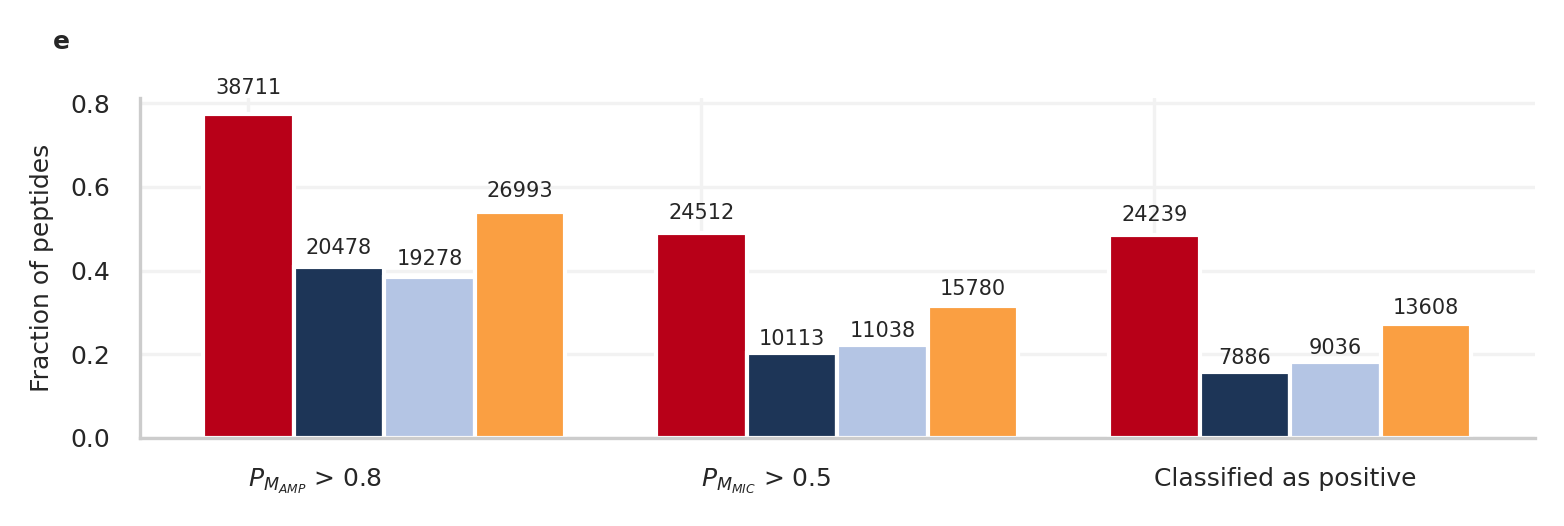

In [90]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(15, 5),  sharey=True)

x = np.arange(3)
fig, ax = plt.subplots(figsize=(6, 1.5), dpi=300)
width = 0.20  # the width of the bars
rects1 = ax.bar(x, hydra_means, width, label='Hydra', color=palette_models['HydrAMP'])
rects2 = ax.bar(x+width, pepcvae_means, width, label='PepCVAE', color=palette_models['PepCVAE'])
rects3 = ax.bar(x+width*2, basic_means, width, label='Basic', color=palette_models['Basic'])
rects4 = ax.bar(x+width*3, ampgan_means, width, label='AMP-GAN', color=palette_models['AMP-GAN'])

# rects5 = ax.bar(x+width*4, deanvae_means, width, label='Dean-VAE', color=pepcvae_color)
# rects6 = ax.bar(x+width*5, mullerlstm_means, width, label='Muller-LSTM', color=basic_color)
# rects7 = ax.bar(x+width*6, ampgan_means, width, label='AMP-GAN', color=basic_color)



ax.set_ylabel('Fraction of peptides')
ax.set_xticks(range(3))


ax.set_xticklabels([
    '$P_{M_{AMP}}$ > 0.8',
    '$P_{M_{MIC}}$ > 0.5',
    'Classified as positive',
], fontdict={'horizontalalignment': 'left'})

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h*50e3),
                ha='center', va='bottom', fontdict={'fontsize': 5})

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)


for i, (label, ax) in enumerate(
    zip(['e',], [ax])
):
    ax.annotate(label, xy=(-0.05, 1.2), xycoords='axes fraction',
      fontweight='bold', va='top', ha='right')
    
plt.show()
fig.savefig("../figures/Fig3_filtering.svg")


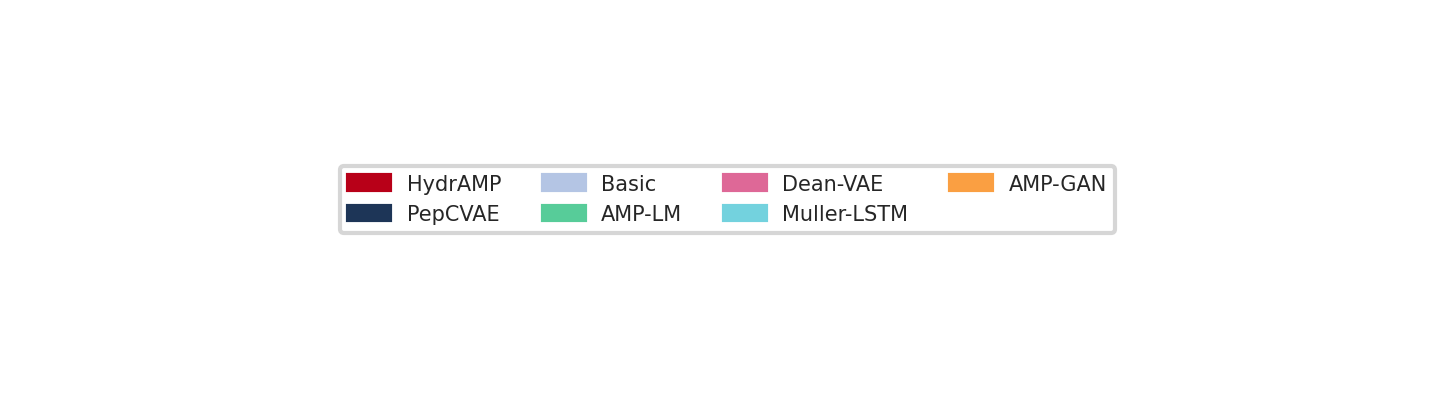

In [91]:

fig, ax1= plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(6, 1.5),
    dpi=300,
)

patches = [mpatches.Patch(color=color, label=label) for label, color in palette_models.items()]
plt.legend(handles=patches, ncol=4,loc='center')

plt.axis('off')
plt.show()
fig.savefig("../figures/Fig3_Legend.svg")
